# Predicting Blood Donors - Driven Data Competition
This dataset is part of a competition on drivendata.org and the goal is to predict who will donate to a blood drive.

***Making this second notebook after learning from my first attempt and reading discussion forum on Driven Data website***

# Data Import and Exploration

In [43]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.metrics import log_loss
from math import log

%matplotlib inline

In [27]:
# read in the training data set
train = pd.read_csv("training_data.csv", index_col=0)
# read in test data set
test = pd.read_csv("test_data.csv", index_col=0)

In [28]:
print("Shape of training data: ", train.shape, "\n")
print("Top 5 rows of training data: \n", train.head(5), "\n")
print("Data types of training data: \n", train.dtypes, "\n")
print("Summary of training data: \n", train.describe(), "\n")
print("Number of missing values in training data: \n", train.isna().sum(), "\n")

Shape of training data:  (576, 5) 

Top 5 rows of training data: 
      Months since Last Donation  Number of Donations  \
619                           2                   50   
664                           0                   13   
441                           1                   16   
160                           2                   20   
358                           1                   24   

     Total Volume Donated (c.c.)  Months since First Donation  \
619                        12500                           98   
664                         3250                           28   
441                         4000                           35   
160                         5000                           45   
358                         6000                           77   

     Made Donation in March 2007  
619                            1  
664                            1  
441                            1  
160                            1  
358                           

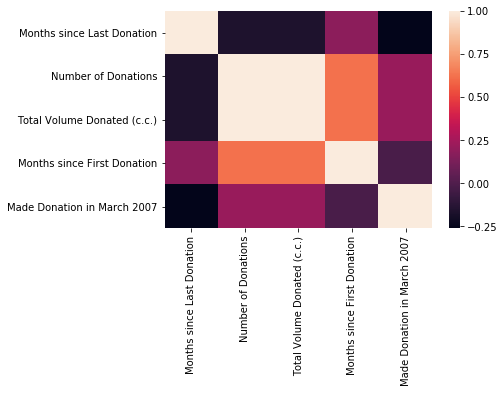

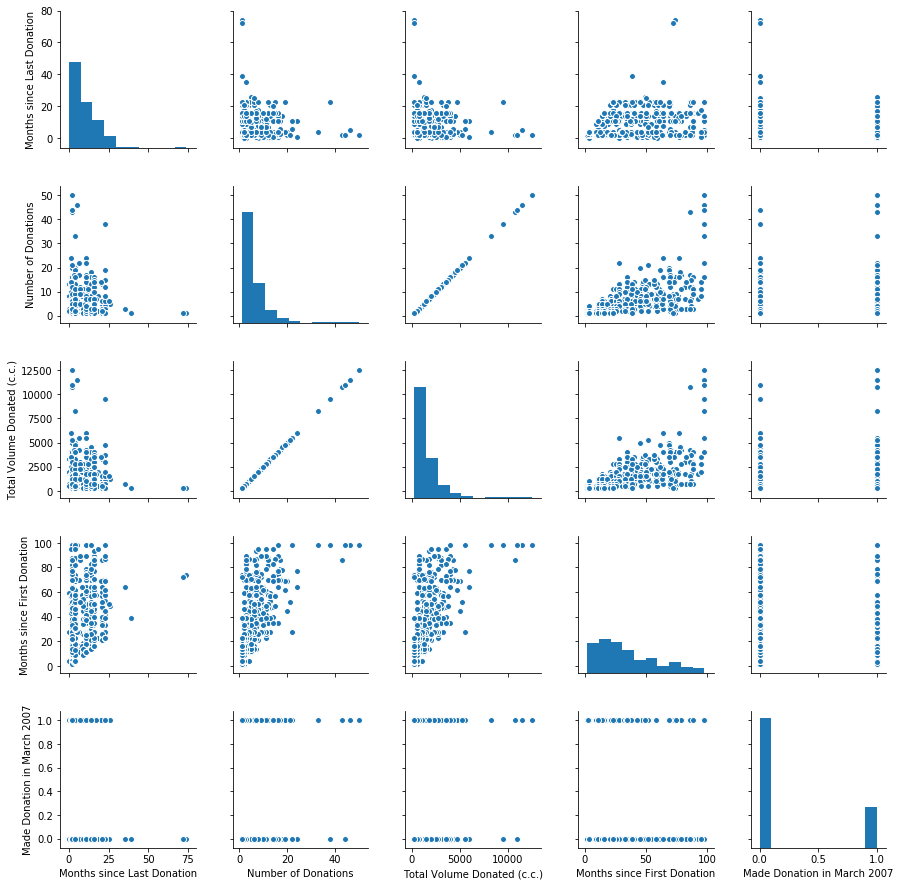

In [29]:
# checking correlation matrix of data frame
corr = train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
sns.pairplot(train)

*** After reading the discussion forum I learned that total volume donated and number of donations are perfectly correlated which can be seen above. The amount donated at each visit is the same every time. Due to this fact I will be removing the total volume donated variable. ***

In [30]:
train = train.drop(columns=["Total Volume Donated (c.c.)"])
train.head()

,Months since Last Donation,Number of Donations,Months since First Donation,Made Donation in March 2007
619,2,50,98,1
664,0,13,28,1
441,1,16,35,1
160,2,20,45,1
358,1,24,77,0


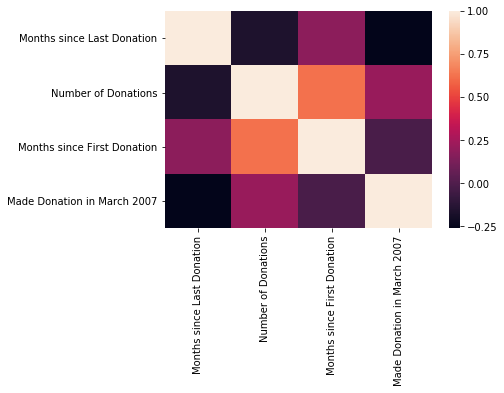

In [31]:
# re-checking correlation matrix of data frame
corr = train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [32]:
# The training data set contains the target label for each row (whether a person donated) so we need
# to remove that and store it before using the data to make predictions
y = train["Made Donation in March 2007"]

# take a look at labels to make sure the correct information is present
print(y[0:10])

# remove the columns 
train = train.drop(columns = ["Made Donation in March 2007"])

# check dataframe to confirm dropped columns
train.head()

619    1
664    1
441    1
160    1
358    0
335    0
47     1
164    0
736    1
436    0
Name: Made Donation in March 2007, dtype: int64


,Months since Last Donation,Number of Donations,Months since First Donation
619,2,50,98
664,0,13,28
441,1,16,35
160,2,20,45
358,1,24,77


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020419AAE4A8>,
      dtype=object)

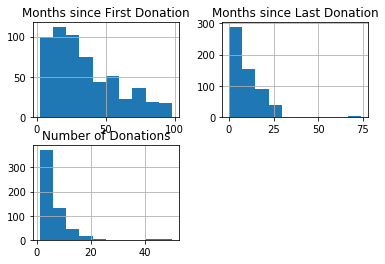

In [33]:
# check histograms of columns
train.hist()

*** For this notebook I am going to leave the outliers in the data since I went through removing them on the first notebook ***

*** This time I am going to compare different scaling techniques (min/max vs. normalizing vs. unscaled). I am also not going to try any transforms in this notebook since it did not significantly change my log loss in the first notebook. ***

### Scaling

     Months since Last Donation  Number of Donations  \
619                   -0.910739             7.772052   
664                   -1.155586             1.320468   
441                   -1.033162             1.843569   
160                   -0.910739             2.541038   
358                   -1.033162             3.238506   

     Months since First Donation  
619                     2.641824  
664                    -0.249946  
441                     0.039231  
160                     0.452341  
358                     1.774293  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020419BF0DD8>,
      dtype=object)

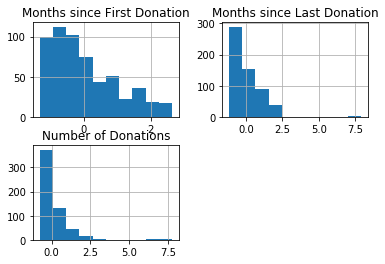

In [34]:
# standardizing data set
std_scale = preprocessing.StandardScaler().fit(train)
train_std = std_scale.transform(train)
# create data frame from scaled data
train_std = pd.DataFrame(train_std, index=train.index, columns=train.columns)
# check top rows and histograms of scaled data
print(train_std.head())
train_std.hist()

     Months since Last Donation  Number of Donations  \
619                    0.027027             1.000000   
664                    0.000000             0.244898   
441                    0.013514             0.306122   
160                    0.027027             0.387755   
358                    0.013514             0.469388   

     Months since First Donation  
619                     1.000000  
664                     0.270833  
441                     0.343750  
160                     0.447917  
358                     0.781250  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020419CBBCC0>,
      dtype=object)

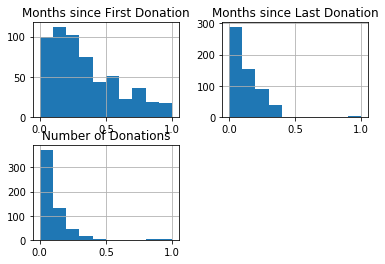

In [35]:
# min/max scaling data
minmax_scale = preprocessing.MinMaxScaler().fit(train)
train_minmax = minmax_scale.transform(train)
# create data frame from scaled data
train_minmax = pd.DataFrame(train_minmax, index=train.index, columns=train.columns)
# check top rows and histograms of scaled data
print(train_minmax.head())
train_minmax.hist()

### Model Evaluation

In [36]:
# create train/test splits (no-scale, std scale, min/max scale) for model evaluation
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = .3, random_state = 1337)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(train_std, y, test_size = .3, random_state = 1337)
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(train, y, test_size = .3, random_state = 1337)

# quick data check
print(X_train.shape)
print(len(y_train))
X_train.head()

(403, 3)
403


,Months since Last Donation,Number of Donations,Months since First Donation
377,2,2,2
425,4,1,4
267,11,2,25
517,11,3,14
602,21,1,21


In [37]:
def random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(random_state=42)
    model = model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:,1]
    return log_loss(y_test,predictions)

print("No scaling: ", random_forest(X_train, X_test, y_train, y_test))
print("Std scaling: ", random_forest(X_train_std, X_test_std, y_train_std, y_test_std))
print("Min/max scaling: ", random_forest(X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax))

No scaling:  2.2586993794738786
Std scaling:  2.2586993794738786
Min/max scaling:  2.2586993794738786


In [42]:
def log_reg(X_train, X_test, y_train, y_test):
    rf_model = LogisticRegression(solver="lbfgs",C=.001, max_iter=500, random_state=42)
    rf_model = rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict_proba(X_test)[:,1]
    return log_loss(y_test,rf_predictions)

print("No scaling: ", log_reg(X_train, X_test, y_train, y_test))
print("Std scaling: ", log_reg(X_train_std, X_test_std, y_train_std, y_test_std))
print("Min/max scaling: ", log_reg(X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax))

No scaling:  0.5443157691239028
Std scaling:  0.5989264939926932
Min/max scaling:  0.5443157691239028


In [46]:
def log_regCV(X_train, X_test, y_train, y_test):
    rf_model = LogisticRegressionCV(solver="lbfgs", max_iter=500, random_state=42, cv=20)
    rf_model = rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict_proba(X_test)[:,1]
    return log_loss(y_test,rf_predictions)

print("No scaling: ", log_regCV(X_train, X_test, y_train, y_test))
print("Std scaling: ", log_regCV(X_train_std, X_test_std, y_train_std, y_test_std))
print("Min/max scaling: ", log_regCV(X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax))

No scaling:  0.5460510983313758
Std scaling:  0.5471894330123143
Min/max scaling:  0.5460510983313758
